In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
def generateNormalVariables(n, normalVar, mu_mean=0, mu_stdev=1, sd_mean=0, sd_stdev=1):

    X = {}

    for j in range(normalVar):
        np.random.seed(seed = j)   #seed for distribution
        random.seed(j)   #seed for random number generator
        
        # The following two lines generate random mean and variance for each predictor from
        # from random normal distributions for each of the mean and standard deviation
        mu = np.random.normal(mu_mean, mu_stdev)
        sigma = abs(np.random.normal(sd_mean, sd_stdev))
        
        X[j] = np.random.normal(mu, sigma, n)
    return X

(array([  5.,  18.,  74., 193., 257., 250., 147.,  38.,  14.,   4.]),
 array([-0.64532212, -0.41714632, -0.18897052,  0.03920528,  0.26738108,
         0.49555687,  0.72373267,  0.95190847,  1.18008427,  1.40826006,
         1.63643586]),
 <a list of 10 Patch objects>)

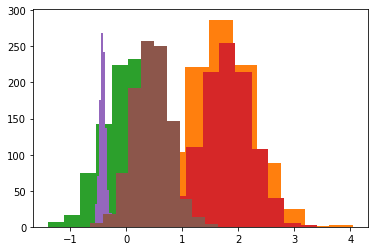

In [3]:
# Visualizing distribution of a few variables from generateNormalVariables (density plots would be better)
var_dict = generateNormalVariables(1000,10)
plt.hist(var_dict[0])
plt.hist(var_dict[1])
plt.hist(var_dict[4])
plt.hist(var_dict[3])
plt.hist(var_dict[2])
plt.hist(var_dict[5])

In [48]:
def generateCountVariables(n, countVar, pois_mean=2):
    X = {}
    
    for i in range(countVar):
        # Created alternative count variable generation method to generate counts from negative binomial distribution.
        # Negative binomial is basically the number of trials to obtain fixed "num" successes when the success probability
        # is p (whereas regular binomial is number of successes for fixed number of trials with success probability p).
        np.random.seed(seed = i)   #seed for distribution
        random.seed(i)   #seed for random number generator
        
        # The following two lines generate random parameters for negative binomial distribution to draw counts from
        # Poisson seemed like a natural choice for "num" successes, and uniform seemed like a natural choice for 
        # generating success probabilities.
        num = np.random.poisson(pois_mean) + 1 #add one to ensure num > 0
        p = np.random.uniform(low=0.8,high=0.9) # Placed some limits on p to avoid insanely high counts     
        X[i] = np.random.negative_binomial(num, p, n)
    return X

(array([713.,   0.,   0., 216.,   0.,   0.,  64.,   0.,   0.,   7.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

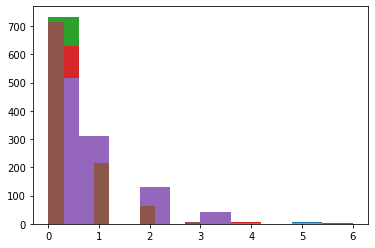

In [49]:
# Visualizing distribution of a few variables from generateCountVariables (density plots would be better)
# Get some decent variability in range of count variable distributions with pois_mean=10
var_dict = generateCountVariables(1000,10,pois_mean=2)
plt.hist(var_dict[0])
plt.hist(var_dict[1])
plt.hist(var_dict[2])
plt.hist(var_dict[3])
plt.hist(var_dict[4])
plt.hist(var_dict[5])

In [50]:
def generateCategoricalVariables(n, catVar, pois_mean = 5):
    temp = {}
    
    for i in range(catVar):
        ### We follow the same principle as count variables. 
        ### But, finally we convert the categorical variables to dummy variables
        ### Note: We use **** k-1 dummy variables **** for k categories (kth variable is baseline)
        
        np.random.seed(seed = i)   #seed for distribution
        random.seed(i)   #seed for random number generator
        
        # Made it so that number of categories is generated randomly (don't have to supply vector)
        noOfCat = np.random.poisson(pois_mean) + 2 #add two to ensure numOfCat > 1
        categories = np.arange(noOfCat)
        population = np.repeat(categories , n)
        random.shuffle(population)
        temp[i] = random.sample(list(population), n)
    #X = pd.DataFrame.from_dict(temp)
    # NOTE: Decided to keep as non-dummy coded dictionary to remain consistent with other variable
    # generation codes
    ### Changed drop_first to True; otherwise we have multicollinearity
    ###X = pd.get_dummies(X,columns=X.columns,drop_first=True)
    return temp

In [51]:
# Visualizing distribution of a few variables from generateCategoricalVariables (density plots would be better)
var_dict = generateCategoricalVariables(10000,10,pois_mean=3)
max(var_dict[9])
#plt.hist(var_dict[0])
#plt.hist(var_dict[1])
#plt.hist(var_dict[2])
#plt.hist(var_dict[3])
#plt.hist(var_dict[4])
#plt.hist(var_dict[5])

1

In [52]:
# RANDOM INTERCEPT SHOULD BE PART OF BETAS; FOR DATA JUST NEED COLUMN OF ONES

#def generateRandomIntercept(n):
#    ### For each observation (X) we generate an intercept
#    np.random.seed(seed = 123)
#    intercept =  np.random.normal(0, 1, n)
#    return intercept

In [53]:
### The following function also needs some cleaning up. 
### It is just generating all types of variables and putting them together
### We also define how many observations, how many of each variable we need to generate here

def generateX():
    
    # Enter Number of Observations
    n = int(input('Enter number of observations:'))
    intercept = np.repeat(1,n) # Create n 1's for intercept column
    X = pd.DataFrame(intercept.reshape(n,1))
    
    # Enter Number of Continuous Variables
    normalVar = int(input('Enter number of continuous variables (normally distributed):'))
    if normalVar != 0:
    #normalVar = 5
        Xnorm = generateNormalVariables(n, normalVar)
        Xnorm = pd.DataFrame.from_dict(Xnorm)
        X = pd.concat([X, Xnorm],ignore_index=True,axis=1)
    
    # Enter Number of Ordinal Variables
    countVar = int(input('Enter number of count variables:'))
    if countVar != 0:
    #maxCount = input('Enter the numbers separated by space: each number correspond to maxCount:')
    #maxCount = list(map(int, maxCount.split()))
    #countVar = 1
    #maxCount = [4]
        Xcnt = generateCountVariables(n, countVar)#Make sure countVar = len(maxCount)
        Xcnt = pd.DataFrame.from_dict(Xcnt)
        X = pd.concat([X, Xcnt],ignore_index=True,axis=1)

    # Enter Number of Nominal Variables
    catVar = int(input('Enter number of categorical variables:'))
    if catVar != 0:
    #catNumber = input('Enter the numbers separated by space: each number correspond to number of categories:')
    #catNumber = list(map(int, catNumber.split()))
    #catVar = 1
    #catNumber = [2]
        Xcat = generateCategoricalVariables(n, catVar)#Make sure catvar = len(catNumber)
        Xcat = pd.DataFrame.from_dict(Xcat)
        Xcat = pd.get_dummies(Xcat, columns=Xcat.columns, drop_first=True)
        # Changed drop_first to True; otherwise we have multicollinearity
        X = pd.concat([X, Xcat],ignore_index=True,axis=1)
    
    return X

In [54]:
generateX()

Enter number of observations:1000
Enter number of continuous variables (normally distributed):1
Enter number of count variables:1
Enter number of categorical variables:0


,0,1,2
0,1,2.155701,1
1,1,2.660762,3
2,1,2.511369,2
3,1,1.372988,0
4,1,2.144237,0
...,...,...,...
995,1,1.801744,2
996,1,1.304828,0
997,1,1.620750,1
998,1,1.986525,0


In [55]:
### This generates q (p+1) random standard normally distributed betas (including random intercept)
### This function needs work
### Either we have to find beta's, which work for all three distributions
### Or we can generate different sets of beta's for different distribution
### I think, same beta's would be better for comparison


def generateRandomBeta(q):
    beta = {}
    for j in range(q):
        random.seed(j)#seed for random number generator
        beta[j] = np.random.normal(0,0.1)
    
    beta = pd.DataFrame(list(beta.items()))
    beta = beta.drop([0],axis=1)
    
    return beta

In [56]:
#a = generateX()
#b = generateRandomBeta(a.shape[1])
#m = a.dot(b)

In [57]:
#for i in np.squeeze(m.values): print(i)

In [58]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [59]:
### This function generates response variable (y)
### As input with X matrix n x (p+1), and beta vector (p+1) x 1
### We also provide the name of the distribution as a quoted string

def generateResponseVariable(X, beta, dist):
    if dist == 'bernoulli':
        meanValues = sigmoid(X.dot(beta)) 
    elif dist == 'poisson':
        meanValues = np.exp(X.dot(beta))
    elif dist == 'exponential':
        meanValues = 1/(X.dot(beta))
    else:
        print('please spell check distribution name, all lowercase: bernoulli, poisson or exponential')
        
    y = []
    
    np.random.seed(123)
    for eachMean in np.squeeze(meanValues.values):
        if dist == 'bernoulli':
            randomPrediction = np.random.binomial(1,eachMean)
        elif dist == 'poisson':
            randomPrediction = np.random.poisson(eachMean)
        elif dist == 'exponential':
            randomPrediction = np.random.exponential(eachMean)
        y.append(randomPrediction)
        print(randomPrediction, eachMean)
    
    return y

In [74]:
### This little function is just commanding to generate X, beta and y
def generateData(dist):
    X = generateX()

    n,q = X.shape
    beta = generateRandomBeta(q)

    y = generateResponseVariable(X, beta, dist) ### dist means pass distribution name as string
    return X, beta, y

In [79]:
X, b, y = generateData('bernoulli')
print(b)
X.head()

Enter number of observations:10000
Enter number of continuous variables (normally distributed):4
Enter number of count variables:4
Enter number of categorical variables:4
0 0.5872706665287803
0 0.34559104638218463
1 0.5293679834407469
0 0.43370640577674574
0 0.6134285382155432
1 0.5263637411565313
0 0.6262086156652872
1 0.34434165999477556
1 0.6770490562355849
0 0.47739161188850743
1 0.5488993640308724
0 0.5910817545019856
1 0.5933156202382606
1 0.5466155468404875
0 0.49687775937341644
0 0.5360033626015541
1 0.5321260530994861
1 0.5243632245200363
1 0.5324924829651181
1 0.5440176782480031
0 0.5233183416643471
0 0.5563816575979993
0 0.5070721227357794
0 0.5028898229616727
0 0.5385798811313279
0 0.49969808712858244
1 0.5812396093203842
1 0.6731751442295558
0 0.4788796141223973
0 0.5541734610956037
1 0.5403283044659246
1 0.580830416846968
1 0.5545238944211214
0 0.49857660409759835
0 0.4011732983140329
1 0.5165558226057287
1 0.7325939050904758
1 0.49421575727991107
1 0.47207508085705235
1 

0 0.5723137314984768
1 0.5804620612731101
0 0.5982576317718556
0 0.531509361214261
1 0.6422298700604657
1 0.527947885906622
1 0.5546431897339652
0 0.5832982217033474
1 0.5997153572050276
0 0.4848709657608847
0 0.47731317742613655
1 0.5179452310046009
1 0.5117747275066354
1 0.5527119249241018
0 0.4861070383331212
1 0.5080537346609898
0 0.5516872050092587
1 0.5676564427225639
1 0.5492584804816801
1 0.4964470434278096
0 0.6181776403594526
0 0.5698075348322968
1 0.5890808871303869
1 0.6200900079092826
1 0.5997768770913555
0 0.5168253267442952
1 0.60297058286536
1 0.6131626922970114
1 0.5823367732812441
1 0.49001865292783675
1 0.620648883498491
1 0.5357256056052498
1 0.6883358906300966
1 0.4789088332595518
1 0.5279539063002514
1 0.5655030738074939
1 0.4673182465626143
0 0.5830944516880698
0 0.5967626834846974
1 0.5585549368572412
1 0.5460105530551935
0 0.5579828406814765
1 0.45075902776280724
0 0.5909172129537011
1 0.5357850606893167
1 0.45459021010448797
1 0.5447096072135981
0 0.5104962509

0 0.47546578526034283
1 0.5142702808318039
1 0.5640022566641305
0 0.5710130345383438
0 0.5243661609048165
0 0.5713032225050951
1 0.5436163669369452
0 0.5941435131447907
0 0.4852953489365147
1 0.5321515208415704
1 0.43932572866364206
0 0.5235872681508051
1 0.5843768432139584
0 0.4831619197713868
0 0.5680656766918509
1 0.6316102557960059
0 0.5508560654503312
0 0.5496613890569065
1 0.6507625924184275
1 0.448792576327957
0 0.5315836246584668
1 0.5818391187010292
0 0.5367705032107821
1 0.556496853324562
0 0.4197330809570171
0 0.4752205145998938
0 0.6101702567366054
0 0.5991234690999768
1 0.6282837955607947
0 0.5778310883490371
0 0.637303306094079
1 0.5812033325710821
1 0.5767354560013405
0 0.5962768602266256
1 0.45569212872782056
1 0.4532029483943833
1 0.5392958291380818
1 0.5559184151825648
1 0.5659194822109224
1 0.5856085886616925
1 0.6005455698180097
1 0.5705944178997064
0 0.5552496033014984
1 0.6294065142916763
0 0.5927989823301268
0 0.5550516019575639
0 0.5651797199456595
1 0.635758164

0 0.6204320021257618
1 0.6254862597085351
0 0.580879502343749
0 0.4825999730441042
1 0.5391996778349836
0 0.47150749656660396
1 0.5609705807815885
1 0.5667285890987583
1 0.5101210167373647
1 0.6373665124484895
0 0.6875453593986355
1 0.5529082633820979
0 0.5385846648871484
1 0.5612694670190652
0 0.5070462862855968
0 0.5128208874398174
0 0.42539362121295154
1 0.548774767904809
1 0.6185083058195369
1 0.7136791019099438
0 0.5147118800381818
0 0.4246754547640957
1 0.6015910562304538
1 0.5529570445204636
1 0.5599108045631788
1 0.5956311531754044
0 0.5718003626775414
1 0.6800868149943163
0 0.49227806130005575
1 0.5822416815044167
0 0.4411694364606694
1 0.6357017816424649
0 0.6124556521490272
1 0.5531165340053182
1 0.5505432506173141
1 0.4648676930558601
0 0.6773345460504432
0 0.4690011878897971
0 0.5531552874667636
0 0.535476762168166
1 0.4453088361772111
0 0.5110180964967838
0 0.5404562158703659
0 0.5606597592091509
1 0.5819958971962549
0 0.5606145589644116
0 0.45763202872284614
1 0.43258074

0 0.5622222528734984
1 0.5230394438268045
1 0.5739815409447486
1 0.448580543552126
1 0.5166374219959894
1 0.6274484902026999
0 0.5003250897465976
1 0.6023732334805566
0 0.5119700824482976
0 0.6106234711089211
0 0.5220060519173025
0 0.5663632792030048
1 0.600958434985883
1 0.5543875322502912
0 0.5480219921283369
0 0.5048729863128116
1 0.6581677624379285
0 0.5376646218765849
1 0.692768545926908
0 0.6091829465692088
0 0.4918134820526933
1 0.6293843177072299
0 0.4659895967380566
0 0.5724597934358938
0 0.5045065680238453
0 0.5718311657592736
1 0.5422493723264141
1 0.6126191366098107
1 0.6247620816563768
0 0.5458968033119334
0 0.49898085223696087
1 0.5558738263056334
0 0.41764112011324594
1 0.5918152291513968
1 0.594063179094184
1 0.5170242432873748
1 0.49553384069564144
0 0.5144985754231127
1 0.48584503385490524
0 0.5136787969412994
0 0.5464643157312064
1 0.56132575941286
1 0.4590260155839348
0 0.5097634582753865
0 0.5629476029725762
1 0.5735975451993162
1 0.5601162094124261
1 0.43922563525

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1,2.155701,1.301233,-0.536955,1.830751,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,1,2.660762,0.967950,-0.324465,0.975196,3,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,2.511369,2.153764,-0.517669,1.667546,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1.372988,0.216364,-0.464120,1.633773,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,2.144237,2.691745,-0.388462,1.752511,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [81]:
print(np.mean(y))
print(np.std(y))
b.head()

0.55
0.49749371855331004


,1
0,-0.046004
1,-0.005792
2,0.207757
3,-0.060131
4,0.093924


In [18]:
### Look at the poisson responses
### The dispersion is too high :(
### One reason that the X's and beta's need careful consideration
generateData('poisson')

Enter number of observations:5
0 1.8888888563301906e-08
125 143.73260331555142
0 2.4509411367799024e-07
289466 288836.245666733
0 4.265803164385503e-11


(          0         1         2         3         4         5  6  7  8
 0 -5.428153  0.668536  0.553898  0.840467  2.393134  0.035891  1  0  1
 1  4.986727  0.151650 -0.393576  1.694675  0.553478  0.244519  1  0  0
 2  1.414892  0.370919 -0.358160 -3.233860  0.090866 -0.449930  0  1  3
 3 -7.531474  0.849247 -0.588999  5.714737 -2.575844  0.334419  0  1  1
 4 -2.893001  0.707762  0.232324 -2.421666 -0.417833 -0.181777  1  0  3,      1
 0  1.0
 1  1.0
 2 -1.5
 3  2.0
 4 -2.5
 5  3.0
 6 -3.5
 7  4.0
 8 -4.5, [0, 125, 0, 289466, 0])

In [17]:
### All X.beta's have to be negative  :(
### One reason that the generation function of X and beta needs work
generateData('exponential')

Enter number of observations:5
0.04475053649569026 0.05622813149145228


ValueError: scale < 0

# Below are the individual functions, which I accumulated above. If you guys think the individual functions are better.....

In [83]:
# def generateBernoulliResponse(X, beta):
#     meanValues = sigmoid(X.dot(beta)) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.binomial(1,eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [88]:
# def generatePoissonResponse(X, beta):
#     meanValues = np.exp(X.dot(beta)) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.poisson(eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [ ]:
# def generateExponentialResponse(X, beta):
#     meanValues = -1/X.dot(beta) ### Applying mean function
#     meanValues = np.array([item for sublist in meanValues.values for item in sublist])
#     y = []
#     for eachMean in meanValues:
#         np.random.seed(int(round(eachMean)))
#         randomPrediction = np.random.exponential(eachMean) ### predict a random number using the mean
#         y.append(randomPrediction)
#         print(randomPrediction, eachMean)
#     return y

In [95]:
# def generateBernoulliData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generateBernoulliResponse(X, beta)
#     return X, beta, y

In [96]:
# def generatePoissonData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generatePoissonResponse(X, beta)
#     return X, beta, y

In [97]:
# def generateExponentialData():
#     X = generateX()

#     n,p = X.shape
#     beta = generateRandomBeta(p)

#     y = generateExponentialResponse(X, beta)
#     return X, beta, y